In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [4]:
# 1. Setup Paths
# Using os.path.expanduser to handle the '~' correctly
DATA_PATH = os.path.expanduser("~/Projects/datasets/letterboxd-film-ratings")
FILMS_FILE = os.path.join(DATA_PATH, "films.csv")
RATINGS_FILE = os.path.join(DATA_PATH, "ratings.csv")

In [5]:
# 2. Load Data
print("Loading data... (This might take a moment if files are huge)")
try:
    # OPTION 1: Robust Loading
    # on_bad_lines='skip' -> If a row is malformed, ignore it and keep going.
    # engine='python' -> Slower but often smarter at handling quoting issues.
    
    df_films = pd.read_csv(FILMS_FILE, on_bad_lines='skip', engine='python')
    print(f"✅ Films loaded (Rows: {len(df_films)})")
    
    # Ratings files are usually cleaner (just numbers), but let's be safe
    df_ratings = pd.read_csv(RATINGS_FILE, on_bad_lines='skip') 
    print(f"✅ Ratings loaded (Rows: {len(df_ratings)})")
    
except Exception as e:
    print(f"❌ Error: {e}")
    print("Please double check your path.")

Loading data... (This might take a moment if files are huge)
✅ Films loaded (Rows: 354834)
✅ Ratings loaded (Rows: 18175545)


In [6]:
# ==========================================
# 3. Basic Inspection
# ==========================================

def inspect_df(name, df):
    print(f"\n{'='*20} {name} OVERVIEW {'='*20}")
    print(f"Shape: {df.shape}")
    print("\n--- Columns & Types ---")
    print(df.dtypes)
    print("\n--- First 5 Rows ---")
    display(df.head()) # 'display()' works in Jupyter, use print() if pure script
    print("\n--- Missing Values ---")
    print(df.isnull().sum())

inspect_df("Films", df_films)
inspect_df("Ratings", df_ratings)


==================== Films OVERVIEW ====================
Shape: (354834, 4)

--- Columns & Types ---
film_id        object
film_name      object
year          float64
poster_url     object
dtype: object

--- First 5 Rows ---


,film_id,film_name,year,poster_url
0,anthem-of-a-teenage-prophet,Anthem of a Teenage Prophet,2018.0,https://a.ltrbxd.com/resized/film-poster/3/8/6...
1,elf-buddys-musical-christmas,Elf: Buddy's Musical Christmas,2014.0,https://a.ltrbxd.com/resized/film-poster/2/3/8...
2,look-at-us-now-mother,"Look at Us Now, Mother!",2016.0,https://a.ltrbxd.com/resized/film-poster/3/2/6...
3,fate-grand-order-absolute-demonic-front-babylonia,Fate/Grand Order Absolute Demonic Front: Babyl...,2019.0,https://a.ltrbxd.com/resized/film-poster/6/7/1...
4,memory-2022,Memory,2022.0,https://a.ltrbxd.com/resized/film-poster/7/3/4...



--- Missing Values ---
film_id          1
film_name        1
year          5983
poster_url       0
dtype: int64

==================== Ratings OVERVIEW ====================
Shape: (18175545, 3)

--- Columns & Types ---
user_name     object
film_id       object
rating       float64
dtype: object

--- First 5 Rows ---


,user_name,film_id,rating
0,kurstboy,spider-man-2,4.5
1,kurstboy,tetsuo-the-iron-man,4.0
2,kurstboy,bram-stokers-dracula,4.5
3,kurstboy,poison-2023,4.5
4,kurstboy,the-rat-catcher-2023,3.5



--- Missing Values ---
user_name    0
film_id      8
rating       0
dtype: int64


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
#  Clean the Data (Crucial Step)
# ==========================================

# Drop the 8 rows in ratings that have no film_id
df_ratings = df_ratings.dropna(subset=['film_id', 'user_name', 'rating'])

# Drop the 1 row in films that has no film_id
df_films = df_films.dropna(subset=['film_id'])

print(f"✅ Data cleaned. Ratings count: {len(df_ratings):,}")



✅ Data cleaned. Ratings count: 18,175,537


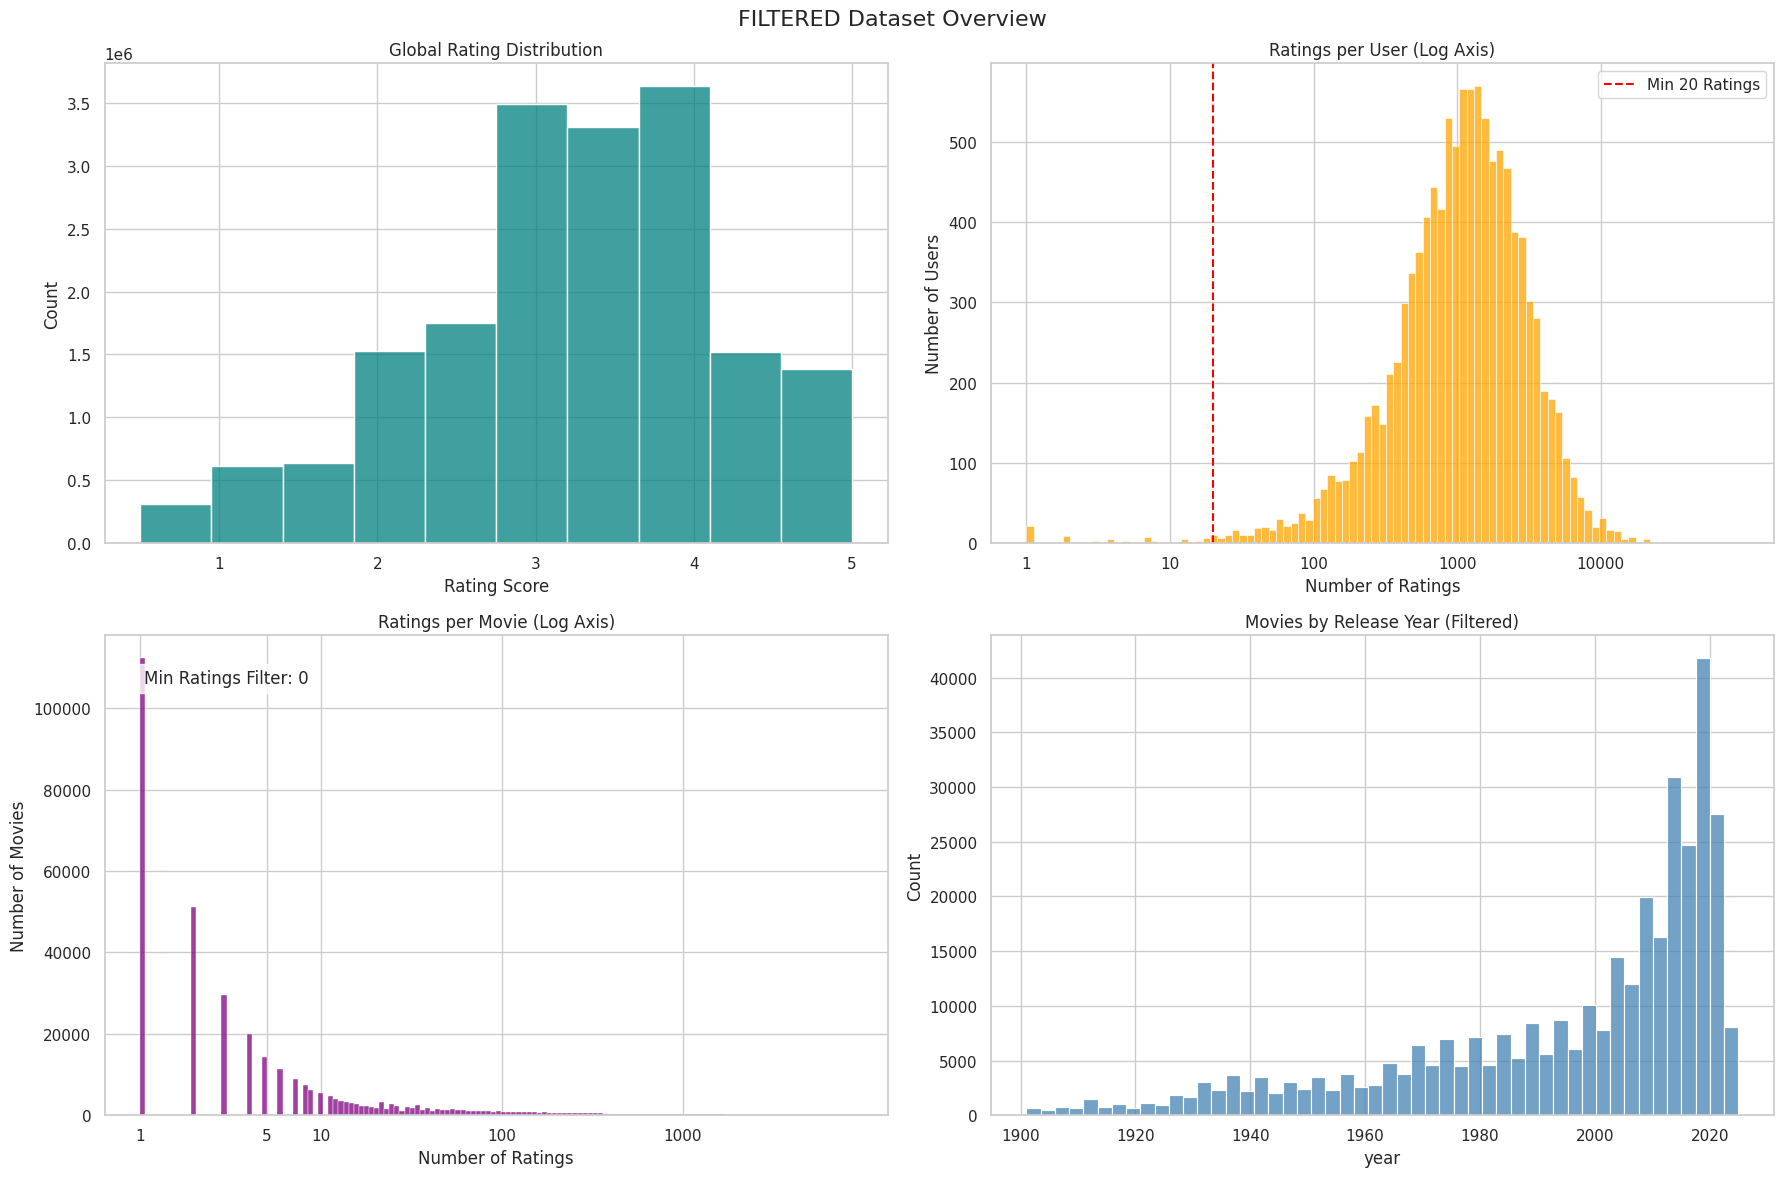


==================== FILTERED STATS ====================
Unique Users: 11,061
Unique Movies: 355,140
Total Interactions: 18,175,537
Sparsity: 99.537307%


In [11]:
# ==========================================
# 2. Visualizations
# ==========================================

from matplotlib.ticker import ScalarFormatter

from data_visualization import plot_graph_stats


plot_graph_stats(df_ratings, df_films, title_prefix="FILTERED")

In [9]:
# ==========================================
# Sparsity Calculation
# ==========================================
n_users = df_ratings['user_name'].nunique()
n_items = df_ratings['film_id'].nunique()
n_ratings = len(df_ratings)

# Avoid division by zero if dataset is empty
if n_users * n_items > 0:
    sparsity = 1 - (n_ratings / (n_users * n_items))
else:
    sparsity = 0

print(f"\n{'='*20} NETWORK STATS {'='*20}")
print(f"Unique Users: {n_users:,}")
print(f"Unique Movies: {n_items:,}")
print(f"Total Interactions: {n_ratings:,}")
print(f"Sparsity: {sparsity:.6%}")
print("Note: GNNs typically handle 99.9% sparsity well, but >99.99% gets tough.")


==================== NETWORK STATS ====================
Unique Users: 11,061
Unique Movies: 355,140
Total Interactions: 18,175,537
Sparsity: 99.537307%
Note: GNNs typically handle 99.9% sparsity well, but >99.99% gets tough.


Loading raw data...
Applying Filter: Keeping only movies with >= 5 ratings...


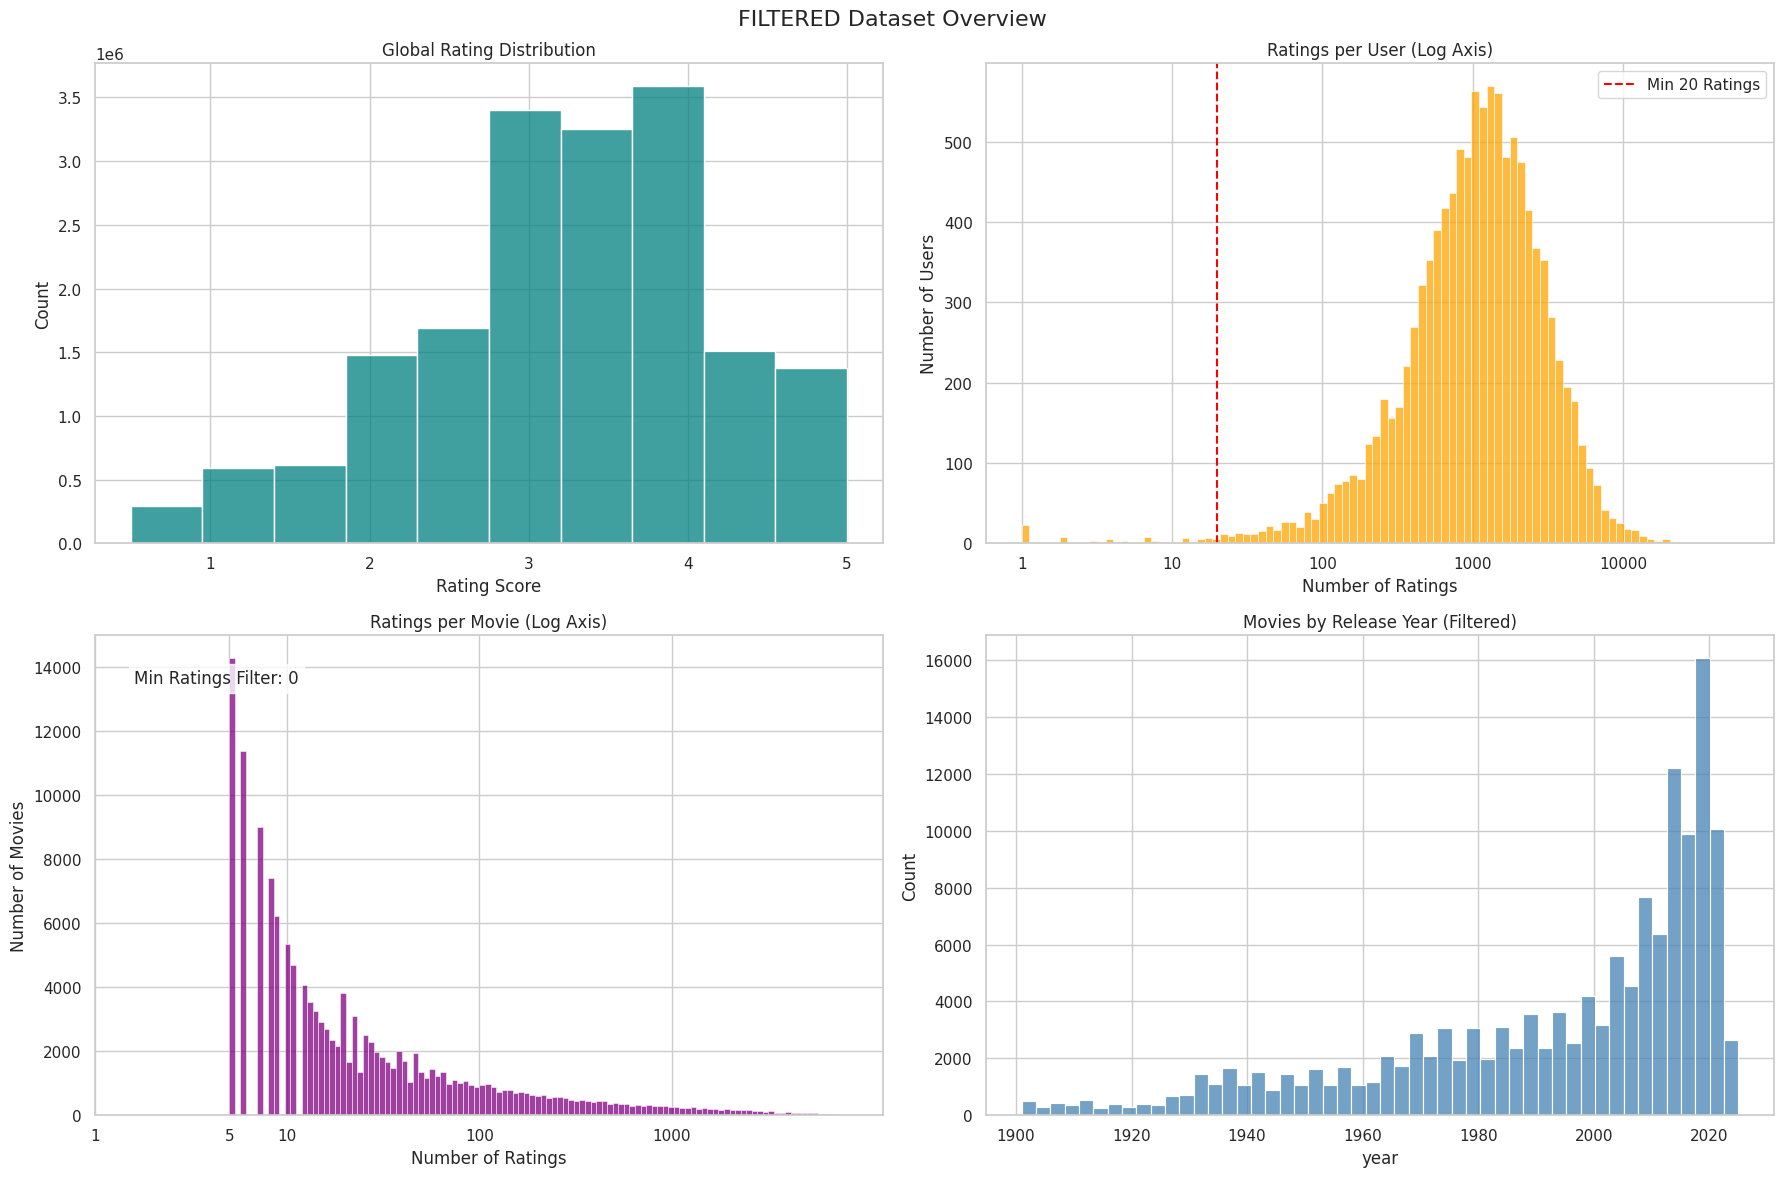


==================== FILTERED STATS ====================
Unique Users: 11,061
Unique Movies: 142,374
Total Interactions: 17,793,097
Sparsity: 98.870135%


In [10]:
# Filter out movies with few ratings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import ScalarFormatter

from data_visualization import plot_graph_stats

# ==========================================
# 1. Configuration
# ==========================================
MIN_RATINGS_PER_MOVIE = 5  # <--- ADJUST THIS to see different results
DATA_PATH = os.path.expanduser("~/Projects/datasets/letterboxd-film-ratings")


# ==========================================
# 3. Main Logic: Load -> Filter -> Plot
# ==========================================

# A. Load Original Data
print("Loading raw data...")
df_ratings_raw = pd.read_csv(os.path.join(DATA_PATH, "ratings.csv"), on_bad_lines='skip')
df_films_raw = pd.read_csv(os.path.join(DATA_PATH, "films.csv"), on_bad_lines='skip', engine='python')

# Basic cleanup (NaNs)
df_ratings_clean = df_ratings_raw.dropna(subset=['film_id', 'user_name', 'rating'])
df_films_clean = df_films_raw.dropna(subset=['film_id'])

# B. Apply Filter
print(f"Applying Filter: Keeping only movies with >= {MIN_RATINGS_PER_MOVIE} ratings...")
movie_counts = df_ratings_clean['film_id'].value_counts()
valid_movies = movie_counts[movie_counts >= MIN_RATINGS_PER_MOVIE].index

df_ratings_filtered = df_ratings_clean[df_ratings_clean['film_id'].isin(valid_movies)]

# C. Plot
plot_graph_stats(df_ratings_filtered, df_films_clean, title_prefix="FILTERED")

In [ ]:
import torch
from torch_geometric.data import HeteroData
import pandas as pd
import numpy as np
import os

# ==========================================
# 1. Configuration
# ==========================================
# We use the same filter you just validated
MIN_RATINGS_PER_MOVIE = 5 
DATA_PATH = os.path.expanduser("~/Projects/datasets/letterboxd-film-ratings")
SAVE_PATH = "/home/eirik/Projects/datasets/letterboxd-film-ratings/processed_graph_data.pt"

# ==========================================
# 2. Load & Apply the Filter Again
# ==========================================
print("Loading and filtering data...")
df_ratings = pd.read_csv(os.path.join(DATA_PATH, "ratings.csv"), on_bad_lines='skip')
df_ratings = df_ratings.dropna(subset=['film_id', 'user_name', 'rating'])

# Apply the filter exactly as you did in the visualization
movie_counts = df_ratings['film_id'].value_counts()
valid_movies = movie_counts[movie_counts >= MIN_RATINGS_PER_MOVIE].index
df_ratings = df_ratings[df_ratings['film_id'].isin(valid_movies)]

print(f"Final Ratings Count: {len(df_ratings):,}")
print(f"Final Movie Count: {df_ratings['film_id'].nunique():,}")

# ==========================================
# 3. Create Integer Mappings (String -> ID)
# ==========================================
print("Mapping IDs...")

# Users
unique_users = df_ratings['user_name'].unique()
user_mapping = {name: i for i, name in enumerate(unique_users)}
df_ratings['user_mapped'] = df_ratings['user_name'].map(user_mapping)

# Movies
unique_movies = df_ratings['film_id'].unique()
movie_mapping = {name: i for i, name in enumerate(unique_movies)}
df_ratings['movie_mapped'] = df_ratings['film_id'].map(movie_mapping)

# ==========================================
# 4. Build the HeteroData Object
# ==========================================
print("Constructing Graph...")
data = HeteroData()

# Define Node Counts
data['user'].num_nodes = len(unique_users)
data['movie'].num_nodes = len(unique_movies)

# Create Edge Index (Source -> Target)
# [2, num_edges] tensor
src = torch.from_numpy(df_ratings['user_mapped'].values).long()
dst = torch.from_numpy(df_ratings['movie_mapped'].values).long()
edge_index = torch.stack([src, dst], dim=0)

# Add Edges: User -> Rates -> Movie
data['user', 'rates', 'movie'].edge_index = edge_index

# Add Edge Attributes (The Rating)
# We convert 0.5-5.0 scale to float tensor
rating_values = torch.from_numpy(df_ratings['rating'].values).float()
data['user', 'rates', 'movie'].edge_attr = rating_values

# Add Reverse Edges (Critical for GNNs!)
# Movie -> Rated_By -> User
data['movie', 'rated_by', 'user'].edge_index = torch.stack([dst, src], dim=0)
data['movie', 'rated_by', 'user'].edge_attr = rating_values

print(data)

# ==========================================
# 5. Save Files
# ==========================================
torch.save(data, SAVE_PATH)

# Save mappings so we can decode predictions later (e.g., ID 50 -> "Pulp Fiction")
pd.DataFrame(list(user_mapping.items()), columns=['user_name', 'id']).to_csv('mapping_users.csv', index=False)
pd.DataFrame(list(movie_mapping.items()), columns=['film_id', 'id']).to_csv('mapping_movies.csv', index=False)

print(f"✅ SUCCESS! Graph saved to {SAVE_PATH}")
print(f"   Saved ID mappings to CSV for later use.")

Loading and filtering data...
Final Ratings Count: 17,793,097
Final Movie Count: 142,374
Mapping IDs...
Constructing Graph...
HeteroData(
  user={ num_nodes=11061 },
  movie={ num_nodes=142374 },
  (user, rates, movie)={
    edge_index=[2, 17793097],
    edge_attr=[17793097],
  },
  (movie, rated_by, user)={
    edge_index=[2, 17793097],
    edge_attr=[17793097],
  }
)


RuntimeError: Parent directory ~/Projects/datasets/letterboxd-film-ratings does not exist.